In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from joblib import parallel_backend, dump, load
import time
import psutil
import os
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import numpy as np

Comparison Table:
         Model  Accuracy  Macro-F1 Score  Precision (Macro)  Recall (Macro)  Training Time (s)  Memory Usage (MB)
 Random Forest      0.98            0.96               0.95            0.96            1544.96             113.25
       XGBoost      0.98            0.95               0.95            0.95             220.16             393.50
      LightGBM      0.98            0.96               0.96            0.95             142.40             388.11
Neural Network      0.88            0.77               0.76            0.79              69.31             453.97

Best Model Based on Macro-F1 Score:
Model                Random Forest
Accuracy                      0.98
Macro-F1 Score                0.96
Precision (Macro)             0.95
Recall (Macro)                0.96
Training Time (s)          1544.96
Memory Usage (MB)           113.25
Name: 0, dtype: object


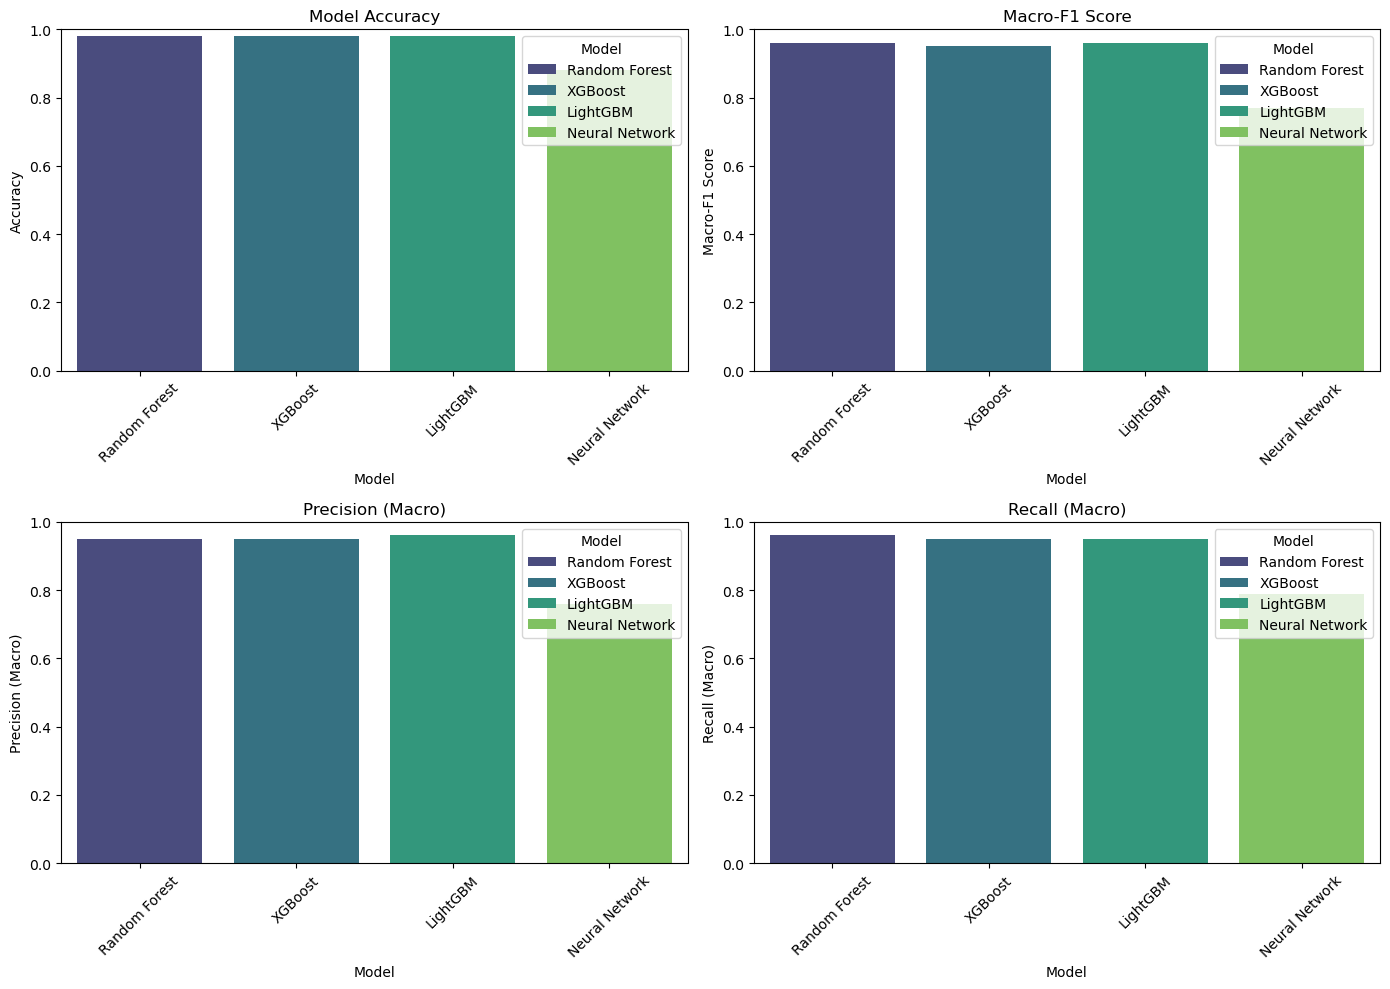

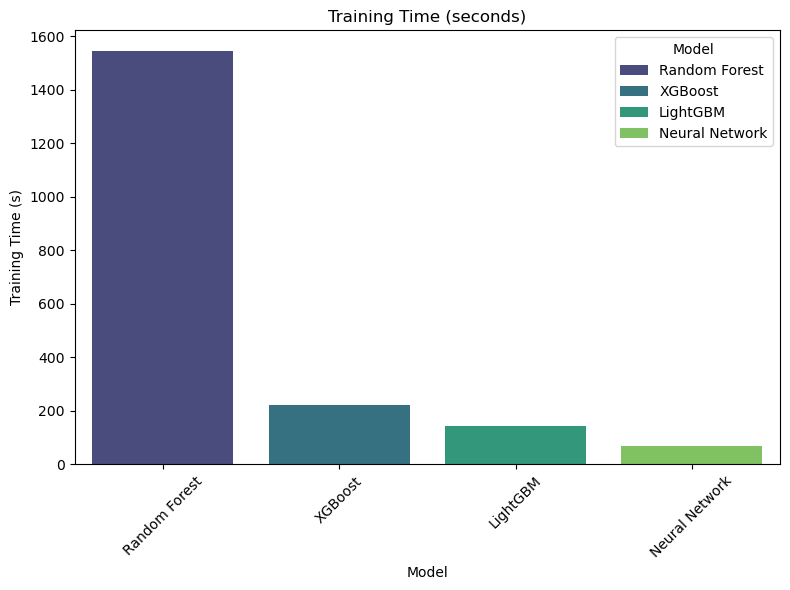

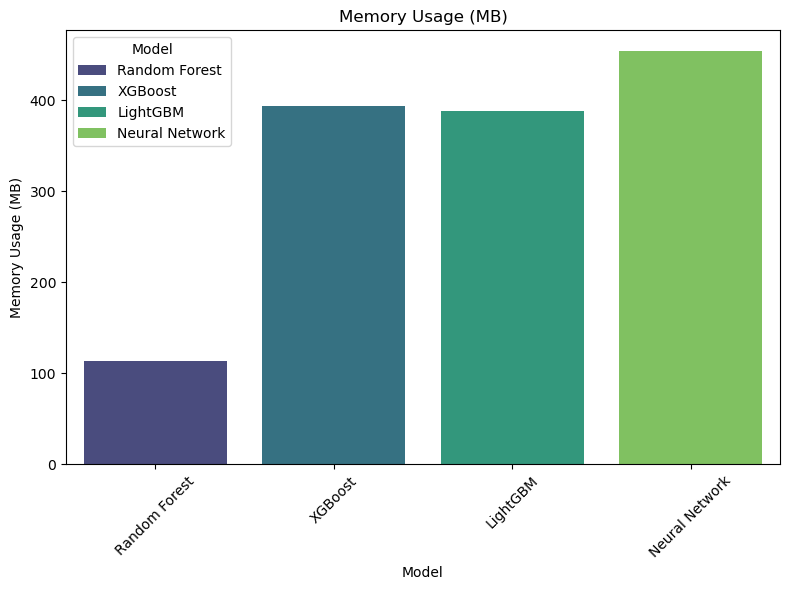

In [4]:
# Data for comparison based on your provided outputs
data = {
    'Model': ['Random Forest', 'XGBoost', 'LightGBM', 'Neural Network'],
    'Accuracy': [0.98, 0.98, 0.98, 0.88],
    'Macro-F1 Score': [0.96, 0.95, 0.96, 0.77],
    'Precision (Macro)': [0.95, 0.95, 0.96, 0.76],
    'Recall (Macro)': [0.96, 0.95, 0.95, 0.79],
    'Training Time (s)': [1544.96, 220.16, 142.40, 69.31],
    'Memory Usage (MB)': [113.25, 393.50, 388.11, 453.97]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Print comparison table
print("Comparison Table:")
print(df.to_string(index=False))

# Find the best model based on Macro-F1 Score
best_model = df.loc[df['Macro-F1 Score'].idxmax()]

# Print the best model
print("\nBest Model Based on Macro-F1 Score:")
print(best_model)

# Set the figure size
plt.figure(figsize=(14, 10))

# Plot for Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=df, palette='viridis', hue='Model', dodge=False)
plt.title('Model Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Plot for Macro-F1 Score
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Macro-F1 Score', data=df, palette='viridis', hue='Model', dodge=False)
plt.title('Macro-F1 Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Plot for Precision (Macro)
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Precision (Macro)', data=df, palette='viridis', hue='Model', dodge=False)
plt.title('Precision (Macro)')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Plot for Recall (Macro)
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Recall (Macro)', data=df, palette='viridis', hue='Model', dodge=False)
plt.title('Recall (Macro)')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Improve layout
plt.tight_layout()
plt.show()

# Plot for Training Time
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Training Time (s)', data=df, palette='viridis', hue='Model', dodge=False)
plt.title('Training Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot for Memory Usage
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Memory Usage (MB)', data=df, palette='viridis', hue='Model', dodge=False)
plt.title('Memory Usage (MB)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Load prepared data
X_train = pd.read_csv(r'D:\Rakesh\Guvi\project\microsoft\Train_split.csv')
y_train = X_train.pop('IncidentGrade')
X_val = pd.read_csv(r'D:\Rakesh\Guvi\project\microsoft\Valid_split.csv')
y_val = X_val.pop('IncidentGrade')

# Initialize SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Initialize Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Define parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 500, 1000],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
    'max_features': ['sqrt', 'log2', None, 0.5, 0.75],  # Number of features to consider for the best split
    'min_samples_split': [2, 5, 10, 15],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 6],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Setup randomized search with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings to sample
    cv=cv,
    scoring='f1_macro',  # Use F1 score for evaluation
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Create pipeline with SMOTE and RandomizedSearchCV
pipeline = Pipeline([
    ('smote', smote),
    ('random_search', random_search)
])

# Train model with randomized search and time tracking
start_time = time.time()
with parallel_backend('loky'):
    pipeline.fit(X_train, y_train)
end_time = time.time()

# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Get the best model
best_rf = pipeline.named_steps['random_search'].best_estimator_

# Evaluate the model on the validation data
y_pred = best_rf.predict(X_val)

# Print results
print(f"Best Hyperparameters: {pipeline.named_steps['random_search'].best_params_}")
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")

# Save the best model as a .pkl file
dump(best_rf, r'D:\Rakesh\Guvi\project\microsoft\best_random_forest_model.pkl')
print("Model saved as best_random_forest_model.pkl")

In [ ]:
# Load prepared data
X_train = pd.read_csv(r'D:\Rakesh\Guvi\project\microsoft\Train_split.csv')
y_train = X_train.pop('IncidentGrade')
X_val = pd.read_csv(r'D:\Rakesh\Guvi\project\microsoft\Valid_split.csv')
y_val = X_val.pop('IncidentGrade')

# Load the trained Random Forest model
best_rf = load(r'D:\Rakesh\Guvi\project\microsoft\best_random_forest_model.pkl')

# Calculate feature importance
print("Calculating Random Forest Built-in Feature Importance...")
feature_importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_val.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display top 10 important features
print("Top 10 Important Features:")
print(feature_importance_df.head(10))

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.title('Top 10 Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

# Make predictions
y_pred = best_rf.predict(X_val)

# Error Analysis
misclassified_indices = np.where(y_pred != y_val)[0]
num_misclassified = len(misclassified_indices)
print(f"Number of misclassifications: {num_misclassified}")

# Display sample of misclassified cases
print("Sample misclassified cases:")
print(X_val.iloc[misclassified_indices].head())

# Evaluate the model's predictions
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

In [ ]:
# Load the saved model
best_model_path = r'D:\Rakesh\Guvi\project\microsoft\best_random_forest_model.pkl'
loaded_model = load(best_model_path)

# Load the test dataset
test_file_path = r'D:\Rakesh\Guvi\project\microsoft\Test.csv'
df_test = pd.read_csv(test_file_path)

# Prepare test data
X_test = df_test.drop(columns=['IncidentGrade'])
y_test = df_test['IncidentGrade']

# Start time for evaluating the model
start_time = time.time()

# Make predictions using the loaded model
y_test_pred = loaded_model.predict(X_test)

# End time for evaluating the model
end_time = time.time()

# Calculate memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Calculate and print the evaluation metrics
print("Test Set Results:")
print(f"Macro-F1 Score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Macro Precision: {precision_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(y_test, y_test_pred, average='macro'):.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred))

# Print training time and memory usage
print(f"Evaluation Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")

In [ ]:
# Load the test dataset
test_file_path = r'D:\Rakesh\Guvi\project\microsoft\Test.csv'
df_test = pd.read_csv(test_file_path)

# Prepare features and target variable
X_test = df_test.drop(columns=['IncidentGrade'])
y_test = df_test['IncidentGrade']

# Initialize logistic regression with default parameters
logreg = LogisticRegression(max_iter=100, solver='liblinear')

# Train-validation split with stratification
# Split the data again for training and validation since it's mentioned as 'Test Dataset'
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, stratify=y_test)

# Train model with time tracking
start_time = time.time()
logreg.fit(X_train, y_train)
end_time = time.time()

# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Evaluate the model on validation data (using the test split as validation here)
y_val_pred = logreg.predict(X_val)

# Print validation results
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")

# Calculate and print the evaluation metrics for the validation set
print("\nValidation Set Results:")
print(f"Macro-F1 Score: {f1_score(y_val, y_val_pred, average='macro'):.4f}")
print(f"Macro Precision: {precision_score(y_val, y_val_pred, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(y_val, y_val_pred, average='macro'):.4f}")

# Evaluate the model on the entire test data (use this if you want to evaluate on the full test set)
y_test_pred = logreg.predict(X_test)

# Calculate and print the evaluation metrics for the test set
print("\nTest Set Results:")
print(f"Macro-F1 Score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Macro Precision: {precision_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(y_test, y_test_pred, average='macro'):.4f}")

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Test Set Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

In [ ]:
# Load the test dataset
test_file_path = r'D:\Rakesh\Guvi\project\microsoft\Test.csv'
df_test = pd.read_csv(test_file_path)

# Prepare features and target variable
X_test = df_test.drop(columns=['IncidentGrade'])
y_test = df_test['IncidentGrade']

# Train-validation split with stratification
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, stratify=y_test)

# Initialize decision tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'ccp_alpha': np.linspace(0, 0.02, 10)  # Pruning parameter
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=decision_tree,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Train model with time tracking
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

# Get the best model
best_decision_tree = grid_search.best_estimator_

# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Evaluate the best model on validation data
y_val_pred = best_decision_tree.predict(X_val)

# Print validation results
print("Best Parameters:")
print(grid_search.best_params_)
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")

# Evaluate the best model on the entire test data
y_test_pred = best_decision_tree.predict(X_test)

# Calculate and print the evaluation metrics for the test set
print("\nTest Set Results:")
print(f"Macro-F1 Score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Macro Precision: {precision_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(y_test, y_test_pred, average='macro'):.4f}")

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Test Set Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

In [ ]:
# Random Forest results as dictionaries
random_forest_report = {
    "accuracy": 0.94,
    "macro avg": {"precision": 0.8353, "recall": 0.8975, "f1-score": 0.8631},
    "weighted avg": {"precision": 0.94, "recall": 0.94, "f1-score": 0.94},
    "Training Time (s)": 4.58,
    "Memory Usage (MB)": 716.82,
    "Confusion Matrix": np.array([[32150, 3093, 1400], [4221, 36314, 1621], [8851, 5701, 299288]])
}

# Logistic Regression results as dictionaries
logistic_regression_report = {
    "accuracy": 0.86,
    "macro avg": {"precision": 0.7201, "recall": 0.6242, "f1-score": 0.6619},
    "weighted avg": {"precision": 0.85, "recall": 0.86, "f1-score": 0.85},
    "Training Time (s)": 45.06,
    "Memory Usage (MB)": 414.65,
    "Confusion Matrix": np.array([[12732, 4742, 19169], [3370, 23731, 15055], [8159, 3714, 301967]])
}

# Decision Tree results as dictionaries
decision_tree_report = {
    "accuracy": 1.00,
    "macro avg": {"precision": 0.9952, "recall": 0.9955, "f1-score": 0.9954},
    "weighted avg": {"precision": 1.00, "recall": 1.00, "f1-score": 1.00},
    "Training Time (s)": 4561.10,
    "Memory Usage (MB)": 129.75,
    "Confusion Matrix": np.array([[36414, 140, 89], [150, 41884, 122], [96, 150, 313594]])
}

# Creating a DataFrame for better visualization
data = {
    "Model": ["Random Forest", "Logistic Regression", "Decision Tree"],
    "Accuracy": [random_forest_report["accuracy"], logistic_regression_report["accuracy"], decision_tree_report["accuracy"]],
    "Macro Avg Precision": [random_forest_report["macro avg"]["precision"], logistic_regression_report["macro avg"]["precision"], decision_tree_report["macro avg"]["precision"]],
    "Macro Avg Recall": [random_forest_report["macro avg"]["recall"], logistic_regression_report["macro avg"]["recall"], decision_tree_report["macro avg"]["recall"]],
    "Macro Avg F1-Score": [random_forest_report["macro avg"]["f1-score"], logistic_regression_report["macro avg"]["f1-score"], decision_tree_report["macro avg"]["f1-score"]],
    "Weighted Avg Precision": [random_forest_report["weighted avg"]["precision"], logistic_regression_report["weighted avg"]["precision"], decision_tree_report["weighted avg"]["precision"]],
    "Weighted Avg Recall": [random_forest_report["weighted avg"]["recall"], logistic_regression_report["weighted avg"]["recall"], decision_tree_report["weighted avg"]["recall"]],
    "Weighted Avg F1-Score": [random_forest_report["weighted avg"]["f1-score"], logistic_regression_report["weighted avg"]["f1-score"], decision_tree_report["weighted avg"]["f1-score"]],
    "Training Time (s)": [random_forest_report["Training Time (s)"], logistic_regression_report["Training Time (s)"], decision_tree_report["Training Time (s)"]],
    "Memory Usage (MB)": [random_forest_report["Memory Usage (MB)"], logistic_regression_report["Memory Usage (MB)"], decision_tree_report["Memory Usage (MB)"]],
    "Time per Accuracy (s)": [random_forest_report["Training Time (s)"]/random_forest_report["accuracy"], logistic_regression_report["Training Time (s)"]/logistic_regression_report["accuracy"], decision_tree_report["Training Time (s)"]/decision_tree_report["accuracy"]],
    "Memory per Accuracy (MB)": [random_forest_report["Memory Usage (MB)"]/random_forest_report["accuracy"], logistic_regression_report["Memory Usage (MB)"]/logistic_regression_report["accuracy"], decision_tree_report["Memory Usage (MB)"]/decision_tree_report["accuracy"]]
}

df = pd.DataFrame(data)

# Print the DataFrame to compare
print("Comparison of Model Performance:")
print(df)

# Visualization using matplotlib and seaborn

# Create subplots for each metric category
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Accuracy
sns.barplot(x='Model', y='Accuracy', data=df, ax=axes[0, 0], palette="viridis")
axes[0, 0].set_title('Model Accuracy Comparison')

# Macro Avg F1-Score
sns.barplot(x='Model', y='Macro Avg F1-Score', data=df, ax=axes[0, 1], palette="viridis")
axes[0, 1].set_title('Model Macro Avg F1-Score Comparison')

# Weighted Avg Precision
sns.barplot(x='Model', y='Weighted Avg Precision', data=df, ax=axes[1, 0], palette="viridis")
axes[1, 0].set_title('Model Weighted Avg Precision Comparison')

# Weighted Avg Recall
sns.barplot(x='Model', y='Weighted Avg Recall', data=df, ax=axes[1, 1], palette="viridis")
axes[1, 1].set_title('Model Weighted Avg Recall Comparison')

# Training Time
sns.barplot(x='Model', y='Training Time (s)', data=df, ax=axes[2, 0], palette="viridis")
axes[2, 0].set_title('Model Training Time Comparison')

# Memory Usage
sns.barplot(x='Model', y='Memory Usage (MB)', data=df, ax=axes[2, 1], palette="viridis")
axes[2, 1].set_title('Model Memory Usage Comparison')

plt.tight_layout()
plt.show()

# Confusion Matrix Heatmaps
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(random_forest_report["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Random Forest Confusion Matrix')

sns.heatmap(logistic_regression_report["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Logistic Regression Confusion Matrix')

sns.heatmap(decision_tree_report["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', ax=ax[2])
ax[2].set_title('Decision Tree Confusion Matrix')

plt.tight_layout()
plt.show()

# Additional Comparison of Time and Memory per Accuracy
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x='Model', y='Time per Accuracy (s)', data=df, ax=axes[0], palette="viridis")
axes[0].set_title('Time per Accuracy Comparison')

sns.barplot(x='Model', y='Memory per Accuracy (MB)', data=df, ax=axes[1], palette="viridis")
axes[1].set_title('Memory per Accuracy Comparison')

plt.tight_layout()
plt.show()